## Preprocessing  data

In [1]:
import pandas as pd

In [2]:
import pandas as pd 

Import data 

In [3]:
import io
df = pd.read_csv('data/covid19_date_stats_n.csv')


In [4]:
df.head()

,ObservationDate,Confirmed,Recovered,Deaths
0,2020-01-22,555.0,28.0,17.0
1,2020-01-23,653.0,30.0,18.0
2,2020-01-24,941.0,36.0,26.0
3,2020-01-25,1438.0,39.0,42.0
4,2020-01-26,2118.0,52.0,56.0


In [5]:
df_o=df.copy()

In [6]:
df.head()

,ObservationDate,Confirmed,Recovered,Deaths
0,2020-01-22,555.0,28.0,17.0
1,2020-01-23,653.0,30.0,18.0
2,2020-01-24,941.0,36.0,26.0
3,2020-01-25,1438.0,39.0,42.0
4,2020-01-26,2118.0,52.0,56.0


In [7]:
df.columns

Index(['ObservationDate', 'Confirmed', 'Recovered', 'Deaths'], dtype='object')

## Death Prediction


Let's start by dropping tracks with missing features:



In [8]:
s = df["Deaths"].isna()
indices = s[s == True].index.values.tolist()
df = df.drop(index=indices)
df = df.reset_index()

Extracting numerical features and the date of every top 200 list:

In [9]:
features = df.select_dtypes(include=["float64"])

In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  81 non-null     float64
 1   Recovered  81 non-null     float64
 2   Deaths     81 non-null     float64
dtypes: float64(3)
memory usage: 2.0 KB


In [11]:
dates = []
for i in range(0, df.shape[0], 3):
    dates.append(df["ObservationDate"][i][:10])

In [12]:
dates

['2020-01-22',
 '2020-01-25',
 '2020-01-28',
 '2020-01-31',
 '2020-02-03',
 '2020-02-06',
 '2020-02-09',
 '2020-02-12',
 '2020-02-15',
 '2020-02-18',
 '2020-02-21',
 '2020-02-24',
 '2020-02-27',
 '2020-03-01',
 '2020-03-04',
 '2020-03-07',
 '2020-03-10',
 '2020-03-13',
 '2020-03-16',
 '2020-03-19',
 '2020-03-22',
 '2020-03-25',
 '2020-03-28',
 '2020-03-31',
 '2020-04-03',
 '2020-04-06',
 '2020-04-09']

Averaging over every top 200 list and backwards filling missing weeks:

In [13]:
feature_mean = pd.DataFrame(columns=features.columns, index=pd.to_datetime(dates))
for feature in features.columns:
    average = []
    for i in range(0, df.shape[0], 3):
        average.append(df[feature][i:i+3].mean())
    feature_mean[feature] = average

In [14]:
feature_mean = feature_mean.asfreq(freq="D", method='bfill')

In [15]:
feature_mean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 2020-01-22 to 2020-04-09
Freq: D
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  79 non-null     float64
 1   Recovered  79 non-null     float64
 2   Deaths     79 non-null     float64
dtypes: float64(3)
memory usage: 2.5 KB


## Manual forecasting using Autoregressive Integrated Moving Average (ARIMA)

In [16]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

ARIMA depend on the values p, d, q

p = number of lags, AR terms

d = order of differencing

q = number of lagged forecast errors, MA terms

In [17]:
timeseries = feature_mean["Deaths"]

Augmented Dickey Fuller (ADF) test to see if the timeseries is stationary:

In [18]:
print("p-value:", adfuller(timeseries.dropna())[1])

p-value: 0.9970730275702467


The p-value is greater than the significance level 0.05 so it is not stationary and differencing is needed, d > 0

#### Finding a value for d using autocorrelation:

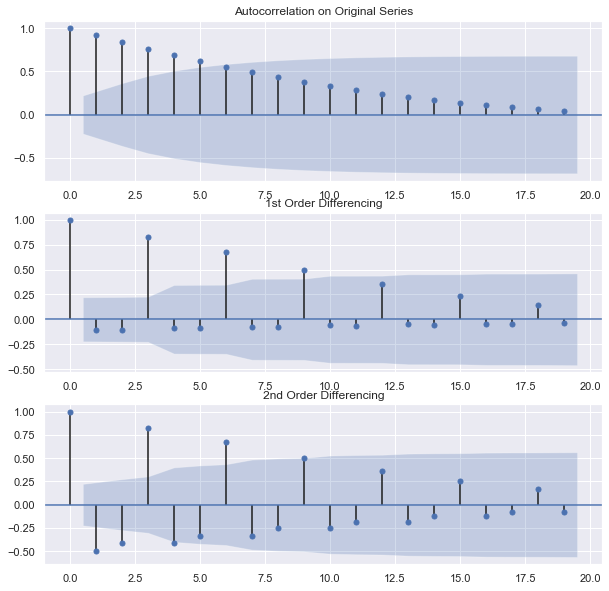

In [19]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1, title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, title="2nd Order Differencing")

The timeseries is stationary at **d = 1** (all but one should be under the significance level) 

If your series is slightly under differenced, try adding an additional AR and if it is slightly over-differenced, maybe add an additional MA term.

#### Value for p is the amount of lags bigger than the significance level in partial autocorrelation

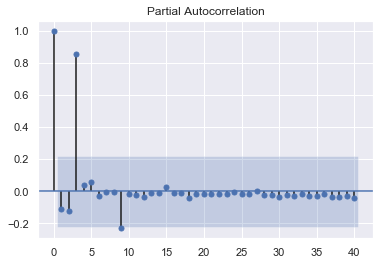

In [20]:
plot_pacf(timeseries.diff().dropna(), lags=40) #knowing d=1 we apply diff() once
plt.show()

Lag 1 is above the signicance level and so **p = 1**.

#### Number of q using autocorrelation on the stationary series:

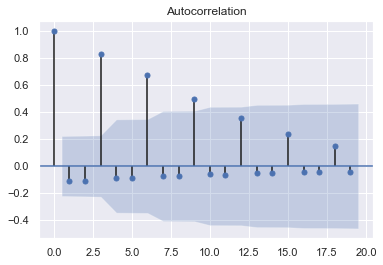

In [21]:
plot_acf(timeseries.diff().dropna())
plt.show()

One above the significance level and thus **q = 1**.

#### Building the model

In [22]:
model = ARIMA(timeseries, order=(1, 1, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Deaths   No. Observations:                   78
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -757.382
Method:                       css-mle   S.D. of innovations           3987.855
Date:                Sat, 02 May 2020   AIC                           1520.763
Time:                        18:04:22   BIC                           1527.833
Sample:                    01-23-2020   HQIC                          1523.594
                         - 04-09-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1312.3023    408.477      3.213      0.001     511.701    2112.903
ar.L1.D.Deaths    -0.1068      0.112     -0.954      0.340      -0.326       0.113
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -9.3620           +0.0000j            9.3620            0.5000
-----------------------------------------------------------------------------
"""

Akaike information criterion (AIC) estimates the relative amount of information lost by a given model. The less the better!

Now for the prediction:

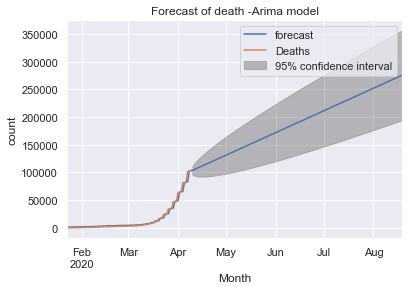

In [23]:
graph = results.plot_predict(1, 210)
plt.title('Forecast of death -Arima model')
plt.ylabel('count')
plt.xlabel('Month')
plt.show()

## Timeseries forecasting using auto_arima

In [24]:
import pmdarima as pm

In [25]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [26]:
def plotarima(n_periods, timeseries, automodel,case_type):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], periods=n_periods, freq="D")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.title("Auto Arima model of "+case_type +" Forecast")
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", alpha=.25)
    plt.legend(("past", "forecast", "95% confidence interval"), loc="upper left")
    plt.show()

In [27]:
automodel = arimamodel(feature_mean["Deaths"])
automodel.summary()

Performing stepwise search to minimize aic


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1484.389, BIC=1493.764, Time=0.270 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1562.399, BIC=1567.087, Time=0.013 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1542.263, BIC=1549.294, Time=0.016 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1493.925, BIC=1500.956, Time=0.112 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=1560.425, BIC=1562.768, Time=0.007 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1255.515, BIC=1267.234, Time=0.277 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1254.441, BIC=1263.817, Time=0.131 seconds
Near non-invertible roots for order (2, 2, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive para

Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1255.311, BIC=1269.374, Time=0.361 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1255.558, BIC=1267.277, Time=0.289 seconds
Near non-invertible roots for order (3, 2, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: (4, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1268.768, BIC=1285.175, Time=0.460 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1251.103, BIC=1267.509, Time=0.427 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1257.576, BIC=1271.638, Time=0.344 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (4, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1267.555, BIC=1286.306, Time=0.421 seconds
Fit ARIMA: (3, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1227.271, BIC=1246.021, Time=0.428 seconds
Near non-invertible roots for order (3, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1229.246, BIC=1245.653, Time=0.330 seconds
Near non-invertible roots for order (2, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (4, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1229.078, BIC=1250.172, Time=0.419 seconds
Near non-invertible roots for order (4, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 4.337 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:               SARIMAX(3, 2, 3)   Log Likelihood                -605.635
Date:                Sat, 02 May 2020   AIC                           1227.271
Time:                        18:04:30   BIC                           1246.021
Sample:                             0   HQIC                          1234.771
                                 - 79                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     31.5021     31.620      0.996      0.319     -30.473      93.477
ar.L1         -0.1220      0.047     -2.602      0.009      -0.214      -0.030
ar.L2         -0.1034      0.047     -2.208      0.027      -0.195      -0.012
ar.L3          0.8878      0.044     20.359      0.000       0.802       0.973
ma.L1         -1.1583      0.187     -6.192      0.000      -1.525      -0.792
ma.L2         -0.2192      0.186     -1.181      0.238      -0.583       0.145
ma.L3          0.6677      0.112      5.950      0.000       0.448       0.888
sigma2      3.622e+05      0.001    3.9e+08      0.000    3.62e+05    3.62e+05
===================================================================================
Ljung-Box (Q):                       84.67   Jarque-Bera (JB):               124.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              52.14   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.03e+24. Standard errors may be unstable.
"""

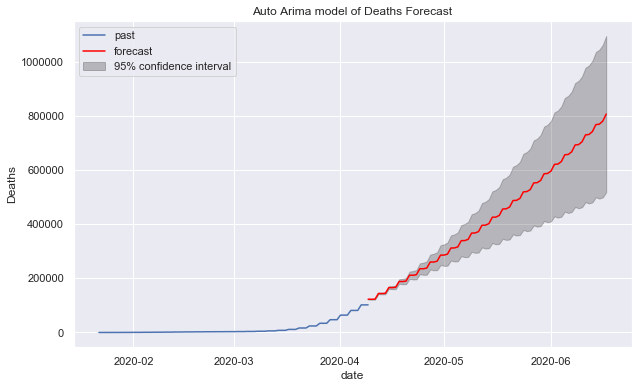

In [28]:
plotarima(70, feature_mean["Deaths"], automodel,"Deaths")

## Discussion

Manually we got (p, d , q) = (1, 1, 1) and auto_arima found the lowest AIC value at the same parameters!

It is much less of a hazzle to use the automatic one, except for it not having a built in plot command, but that is a minor flaw IMO.

Hope this brief summary of ARIMA proved useful :)

# Confirmed cases prediction

In [29]:
df_c=df.copy()

In [30]:
s = df_c["Confirmed"].isna()
indices = s[s == True].index.values.tolist()
df = df_c.drop(index=indices)
df = df_c.reset_index()

In [31]:
features = df.select_dtypes(include=["float64"])

In [32]:
dates = []
for i in range(0, df.shape[0], 3):
    dates.append(df["ObservationDate"][i][:10])

In [33]:
feature_mean = pd.DataFrame(columns=features.columns, index=pd.to_datetime(dates))
for feature in features.columns:
    average = []
    for i in range(0, df.shape[0], 3):
        average.append(df[feature][i:i+3].mean())
    feature_mean[feature] = average

In [34]:
feature_mean = feature_mean.asfreq(freq="D", method='bfill')

In [35]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [36]:
timeseries = feature_mean["Confirmed"]

In [37]:
print("p-value:", adfuller(timeseries.dropna())[1])

p-value: 0.9937535456391174


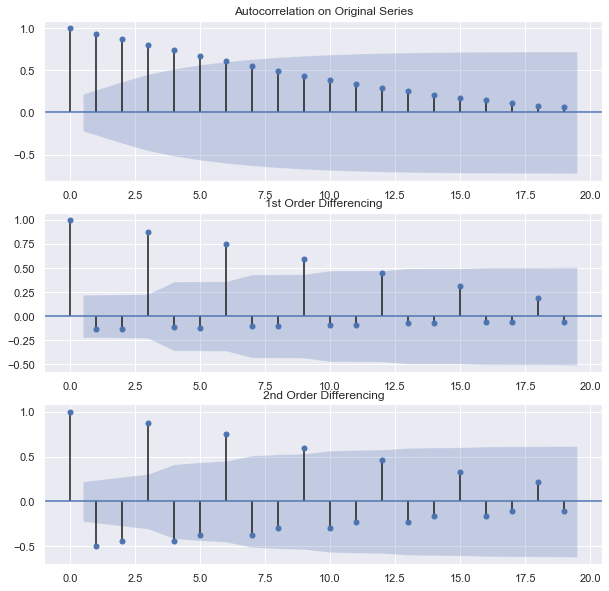

In [38]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1, title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, title="2nd Order Differencing")

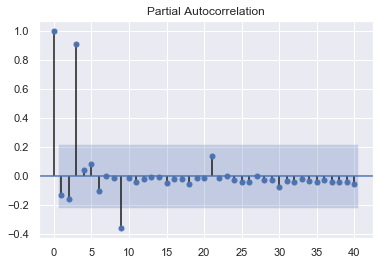

In [39]:
plot_pacf(timeseries.diff().dropna(), lags=40) #knowing d=1 we apply diff() once
plt.show()

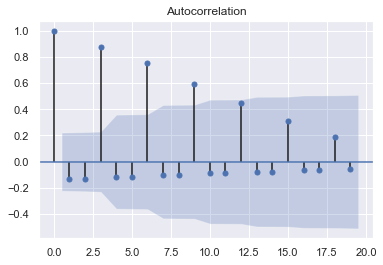

In [40]:
plot_acf(timeseries.diff().dropna())
plt.show()

In [41]:
model = ARIMA(timeseries, order=(1, 1, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Confirmed   No. Observations:                   78
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -967.763
Method:                       css-mle   S.D. of innovations          59170.011
Date:                Sat, 02 May 2020   AIC                           1941.526
Time:                        18:04:32   BIC                           1948.596
Sample:                    01-23-2020   HQIC                          1944.357
                         - 04-09-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.161e+04   5931.174      3.643      0.000    9983.805    3.32e+04
ar.L1.D.Confirmed    -0.1313      0.112     -1.176      0.240      -0.350       0.088
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -7.6153           +0.0000j            7.6153            0.5000
-----------------------------------------------------------------------------
"""

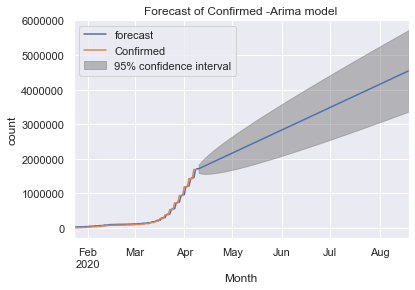

In [42]:
graph = results.plot_predict(1, 210)
plt.title('Forecast of Confirmed -Arima model')
plt.ylabel('count')
plt.xlabel('Month')
plt.show()

In [43]:
automodel = arimamodel(feature_mean["Confirmed"])
automodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1922.109, BIC=1931.484, Time=0.038 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1979.910, BIC=1984.598, Time=0.010 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1959.765, BIC=1966.797, Time=0.011 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1943.146, BIC=1950.178, Time=0.027 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=1977.936, BIC=1980.279, Time=0.007 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1654.248, BIC=1665.967, Time=0.252 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1650.532, BIC=1659.907, Time=0.192 seconds
Near non-invertible roots for order (2, 2, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive para

Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1656.313, BIC=1670.376, Time=0.296 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1653.584, BIC=1667.647, Time=0.341 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1927.039, BIC=1938.758, Time=0.075 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1653.019, BIC=1669.425, Time=0.333 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (4, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1652.045, BIC=1670.795, Time=0.361 seconds
Near non-invertible roots for order (4, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (3, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1642.462, BIC=1661.212, Time=0.347 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1640.404, BIC=1656.810, Time=0.351 seconds
Fit ARIMA: (1, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1915.062, BIC=1929.125, Time=0.054 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (2, 2, 4)x(0, 0, 0, 0) (constant=True); AIC=1636.338, BIC=1655.088, Time=0.384 seconds
Fit ARIMA: (1, 2, 4)x(0, 0, 0, 0) (constant=True); AIC=1918.350, BIC=1934.757, Time=0.149 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (3, 2, 4)x(0, 0, 0, 0) (constant=True); AIC=1635.894, BIC=1656.988, Time=0.424 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (4, 2, 4)x(0, 0, 0, 0) (constant=True); AIC=1637.122, BIC=1660.560, Time=0.463 seconds
Near non-invertible roots for order (4, 2, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (3, 2, 5)x(0, 0, 0, 0) (constant=True); AIC=1636.348, BIC=1659.786, Time=0.478 seconds
Near non-invertible roots for order (3, 2, 5)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (2, 2, 5)x(0, 0, 0, 0) (constant=True); AIC=1640.633, BIC=1661.727, Time=0.431 seconds
Near non-invertible roots for order (2, 2, 5)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (4, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1643.049, BIC=1664.144, Time=0.445 seconds
Fit ARIMA: (4, 2, 5)x(0, 0, 0, 0) (constant=True); AIC=1636.974, BIC=1662.756, Time=0.520 seconds
Near non-invertible roots for order (4, 2, 5)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 6.019 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:               SARIMAX(3, 2, 4)   Log Likelihood                -808.947
Date:                Sat, 02 May 2020   AIC                           1635.894
Time:                        18:04:39   BIC                           1656.988
Sample:                             0   HQIC                          1644.332
                                 - 79                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3286.0299   3507.046      0.937      0.349   -3587.654    1.02e+04
ar.L1         -1.4958      0.166     -9.027      0.000      -1.821      -1.171
ar.L2         -1.4911      0.174     -8.560      0.000      -1.833      -1.150
ar.L3         -0.4888      0.175     -2.788      0.005      -0.833      -0.145
ma.L1          0.6409      0.215      2.978      0.003       0.219       1.063
ma.L2         -0.2889      0.191     -1.509      0.131      -0.664       0.086
ma.L3          0.0219      0.132      0.166      0.868      -0.236       0.280
ma.L4          0.5695      0.147      3.872      0.000       0.281       0.858
sigma2      9.208e+07      0.236   3.89e+08      0.000    9.21e+07    9.21e+07
===================================================================================
Ljung-Box (Q):                       52.00   Jarque-Bera (JB):                52.78
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):              12.99   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+24. Standard errors may be unstable.
"""

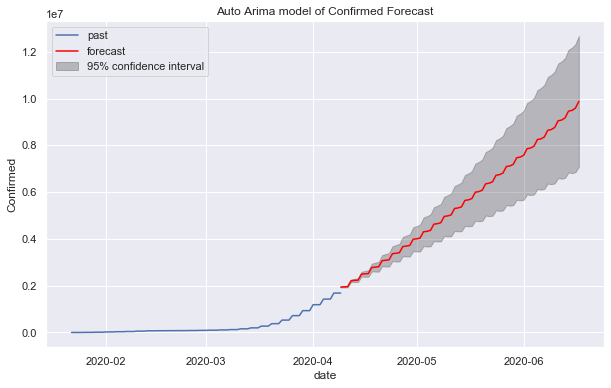

In [44]:
plotarima(70, feature_mean["Confirmed"], automodel,"Confirmed")

## Recovered forecasting

In [45]:
df_r=df_o.copy()

In [46]:
s = df_r["Recovered"].isna()
indices = s[s == True].index.values.tolist()
df = df_r.drop(index=indices)
df = df_r.reset_index()

In [47]:
features = df.select_dtypes(include=["float64"])

In [48]:
dates = []
for i in range(0, df.shape[0], 3):
    dates.append(df["ObservationDate"][i][:10])

In [49]:
feature_mean = pd.DataFrame(columns=features.columns, index=pd.to_datetime(dates))
for feature in features.columns:
    average = []
    for i in range(0, df.shape[0], 3):
        average.append(df[feature][i:i+3].mean())
    feature_mean[feature] = average

In [50]:
feature_mean = feature_mean.asfreq(freq="D", method='bfill')

In [51]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [52]:
timeseries = feature_mean["Recovered"]

In [53]:
print("p-value:", adfuller(timeseries.dropna())[1])

p-value: 0.9970645535982524


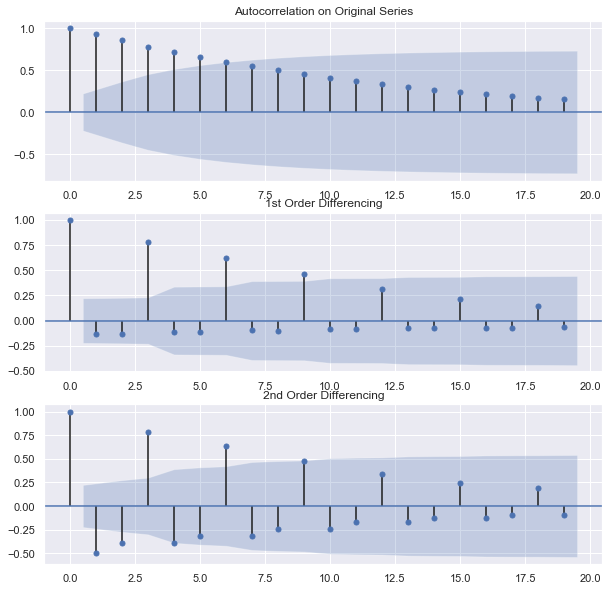

In [54]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1, title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, title="2nd Order Differencing")

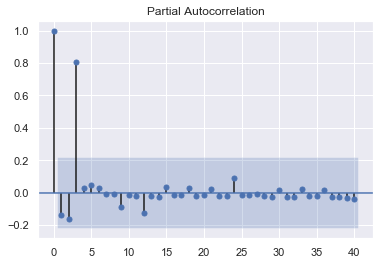

In [55]:
plot_pacf(timeseries.diff().dropna(), lags=40) #knowing d=1 we apply diff() once
plt.show()

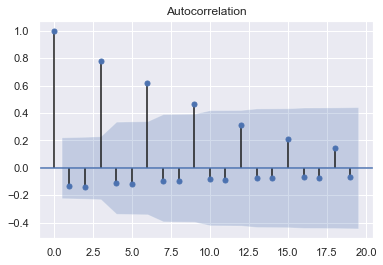

In [56]:
plot_acf(timeseries.diff().dropna())
plt.show()

In [57]:
model = ARIMA(timeseries, order=(1, 1, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Recovered   No. Observations:                   78
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -850.052
Method:                       css-mle   S.D. of innovations          13082.683
Date:                Sat, 02 May 2020   AIC                           1706.104
Time:                        18:04:41   BIC                           1713.174
Sample:                    01-23-2020   HQIC                          1708.934
                         - 04-09-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4837.9786   1307.578      3.700      0.000    2275.174    7400.783
ar.L1.D.Recovered    -0.1347      0.112     -1.206      0.228      -0.353       0.084
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -7.4257           +0.0000j            7.4257            0.5000
-----------------------------------------------------------------------------
"""

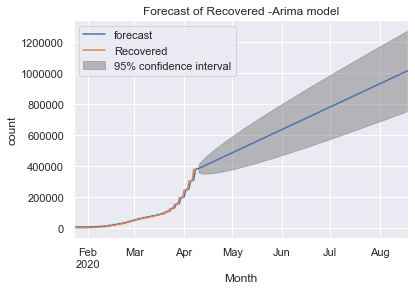

In [58]:
graph = results.plot_predict(1, 210)
plt.title('Forecast of Recovered -Arima model')
plt.ylabel('count')
plt.xlabel('Month')
plt.show()

In [59]:
automodel = arimamodel(feature_mean["Recovered"])
automodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1696.566, BIC=1705.941, Time=0.046 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1747.794, BIC=1752.481, Time=0.009 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1727.650, BIC=1734.681, Time=0.015 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1679.040, BIC=1686.071, Time=0.119 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=1745.819, BIC=1748.163, Time=0.008 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1465.423, BIC=1477.142, Time=0.243 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1463.769, BIC=1473.145, Time=0.174 seconds
Near non-invertible roots for order (2, 2, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1491.698, BIC=1505.761, Time=0.319 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1464.865, BIC=1478.928, Time=0.331 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1669.368, BIC=1681.087, Time=0.330 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1500.936, BIC=1517.343, Time=0.345 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1430.819, BIC=1447.226, Time=0.337 seconds
Near non-invertible roots for order (2, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: (1, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1606.518, BIC=1620.581, Time=0.307 seconds
Near non-invertible roots for order (1, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1465.510, BIC=1484.260, Time=0.335 seconds
Near non-invertible roots for order (3, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 2.939 seconds


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:               SARIMAX(2, 2, 3)   Log Likelihood                -708.409
Date:                Sat, 02 May 2020   AIC                           1430.819
Time:                        18:04:44   BIC                           1447.226
Sample:                             0   HQIC                          1437.381
                                 - 79                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1211.0108    915.469      1.323      0.186    -583.276    3005.298
ar.L1         -1.0096      0.041    -24.422      0.000      -1.091      -0.929
ar.L2         -1.0000      0.035    -28.871      0.000      -1.068      -0.932
ma.L1         -0.1614      2.871     -0.056      0.955      -5.788       5.465
ma.L2         -0.1610      2.925     -0.055      0.956      -5.893       5.571
ma.L3          0.9997      0.277      3.608      0.000       0.457       1.543
sigma2      5.075e+06   3.97e-05   1.28e+11      0.000    5.08e+06    5.08e+06
===================================================================================
Ljung-Box (Q):                       55.73   Jarque-Bera (JB):               222.74
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              23.59   Skew:                             2.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.29e+30. Standard errors may be unstable.
"""

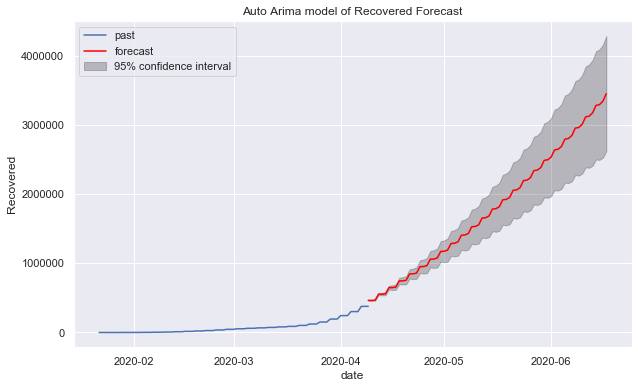

In [60]:
plotarima(70, feature_mean["Recovered"], automodel,"Recovered")